### Table of Contents

* [Model](#Model)
* [Visualising accuracy - ROC / AUC](#rocauc)



## Model <a class="anchor" id="model"></a>

In [31]:
# import libraries
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats

In [32]:
df_original = pd.read_excel(r'creditcardmarketing.xlsx')

In [33]:
df = df_original

In [34]:
df.columns = df.columns.str.replace(' ', '_')
df.columns= df.columns.str.lower()
df.columns= df.columns.str.replace('#_', '')


In [35]:
col_miss_values= ['average_balance', 'q2_balance', 'q3_balance', 'q4_balance']

mean_average_balance = df['average_balance'].mean()
df['average_balance'] = df['average_balance'].fillna(mean_average_balance)
df['average_balance'] = pd.to_numeric(df['average_balance'], errors = 'coerce')

mean_q2_balance = df['q2_balance'].mean()
df['q2_balance'] = df['q2_balance'].fillna(mean_q2_balance)
df['q2_balance'] = pd.to_numeric(df['q2_balance'], errors = 'coerce')

mean_q3_balance = df['q3_balance'].mean()
df['q3_balance'] = df['q3_balance'].fillna(mean_q3_balance)
df['q3_balance'] = pd.to_numeric(df['q3_balance'], errors = 'coerce')

mean_q4_balance = df['q4_balance'].mean()
df['q4_balance'] = df['q4_balance'].fillna(mean_q4_balance)
df['q4_balance'] = pd.to_numeric(df['q4_balance'], errors = 'coerce')



In [36]:
df=df.drop(['customer_number','q1_balance'], axis=1)


In [37]:
# find quartiles
cols_outliers = [ 'q2_balance', 'q3_balance', 'q4_balance', 'average_balance']

for col in cols_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print('Q1 of the column ', col,':', Q1)
    print('Q3 of the column ', col,':', Q3)
    print('IRQ of the column ', col,':', IQR)
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    print('lower_whisker: ', Lower_Whisker, ',' , 'upper whisker: ', Upper_Whisker)
    #  Outlier Treatment 
    df = df[df[col]< Upper_Whisker]
    df = df[df[col]> Lower_Whisker]


Q1 of the column  q2_balance : 658.0
Q3 of the column  q2_balance : 1344.0
IRQ of the column  q2_balance : 686.0
lower_whisker:  -371.0 , upper whisker:  2373.0
Q1 of the column  q3_balance : 632.0
Q3 of the column  q3_balance : 1497.0
IRQ of the column  q3_balance : 865.0
lower_whisker:  -665.5 , upper whisker:  2794.5
Q1 of the column  q4_balance : 375.0
Q3 of the column  q4_balance : 1205.5
IRQ of the column  q4_balance : 830.5
lower_whisker:  -870.75 , upper whisker:  2451.25
Q1 of the column  average_balance : 791.75
Q3 of the column  average_balance : 1152.0
IRQ of the column  average_balance : 360.25
lower_whisker:  251.375 , upper whisker:  1692.375


In [38]:
cat = df.select_dtypes(include = np.object)

In [39]:
cols = list(df.columns)
cols = cols[1:]+[cols[0]]
df = df[cols]

In [40]:
df['average_balance'] = pd.to_numeric(df.average_balance, errors='coerce')
df['q2_balance'] = pd.to_numeric(df.q2_balance, errors='coerce')
df['q3_balance'] = pd.to_numeric(df.q3_balance, errors='coerce')
df['q4_balance'] = pd.to_numeric(df.q4_balance, errors='coerce')


In [41]:
numerics = ['int64', 'float64']
df_num = df.select_dtypes(include=numerics)

In [42]:
df = df.reset_index(drop = True)

In [43]:
cat = df.select_dtypes(exclude = ['float64'])

In [44]:
cat_col=cat.columns.to_list()

In [45]:
categorical = pd.get_dummies(cat, columns =['reward',
 'mailer_type',
 'income_level',
 'bank_accounts_open',
 'overdraft_protection',
 'credit_rating',
 'credit_cards_held',
 'homes_owned',
 'household_size',
 'own_your_home',
 'offer_accepted'],drop_first=True)

In [46]:
from sklearn.preprocessing import Normalizer

In [47]:
X = df_num.drop(['bank_accounts_open', 'credit_cards_held', 'homes_owned', "household_size"], axis=1)
transformer = Normalizer().fit(X)
X_normalised= transformer.transform(X)
X_normalised = pd.DataFrame(X_normalised)

In [48]:
y= categorical['offer_accepted_Yes']
categorical=categorical.drop(['offer_accepted_Yes'], axis=1)

In [49]:
X = np.concatenate((X_normalised, categorical),axis=1)



In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.4, random_state=40)

In [52]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

In [53]:
from sklearn.metrics import accuracy_score 
predictions = classification.predict(X_test)

In [54]:
predictions

array([0, 1, 1, ..., 0, 0, 1], dtype=uint8)

In [55]:
accuracy_score(y_test, predictions)

0.7034989272157122

### Visualising accuracy - ROC / AUC  <a class="anchor" id="rocauc"></a>

In [56]:
import sklearn.metrics as metrics 
probs = classification.predict_proba(X_test)
preds =probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.770045343064312


In [57]:
#definitions 
# tpr = true positive rate 
# fpr = false positive rate

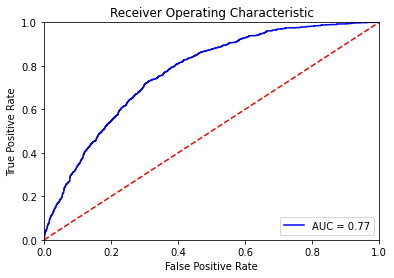

In [58]:
# method to plot AUC visually 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

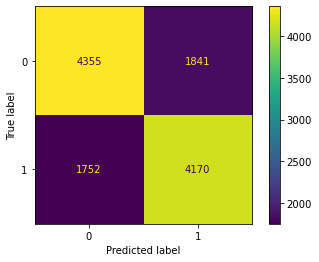

In [59]:
# confusion matrix 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix

accuracy_score(y_test,predictions)
confusion_matrix(y_test,predictions)
plot_confusion_matrix(classification, X_test, y_test)
plt.show()
